# Optimized PyTorch CNN with Optuna

In this notebook, we optimize a convolutional neural network (CNN) for the CIFAR-10 dataset using Optuna for hyperparameter tuning.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Package imports
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)
from cifar10_tools.pytorch.training import train_model

# Suppress Optuna info messages (show only warnings and errors)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Fixed hyperparameters

In [ ]:
batch_size = 2048        # Training images come in 5 batches of 10,000

# Optuna settings
run_optimization = True  # Run optimization or load results from disk for evaluation
start_new_study = True   # Clear previous results (if any) and start new study or resume 
n_trials = 200           # Number of optimization trials
n_epochs_per_trial = 50  # Epochs per trial
n_epochs_final = 100     # Epochs for final model training

# SQLite storage for Optuna (local file)
data_dir = Path('../data/pytorch')
data_dir.mkdir(parents=True, exist_ok=True)
storage_path = data_dir / 'cnn_optimization.db'
storage_url = f'sqlite:///{storage_path}'

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes. We convert the images to grayscale for this demonstration.

### 1.1. Load datasets

In [ ]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: convert to tensor, and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=False,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.2. Visualize sample images

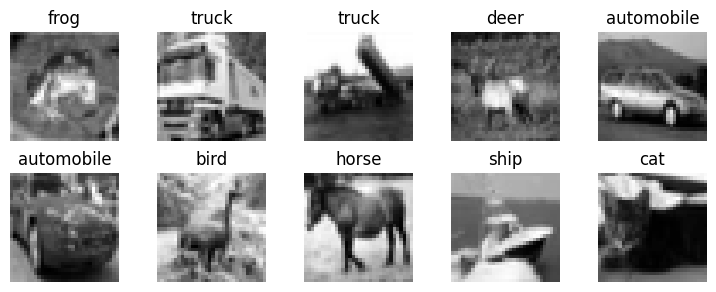

In [ ]:
# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(train_dataset, class_names)
plt.show()

### 1.2. Create training, validation and testing tensors

In [5]:
# Reshape and preload entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


### 1.3. Create `DataLoader()` objects

In [6]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 20
Validation batches: 5
Test batches: 5


## 2. Define CNN architecture with configurable hyperparameters

We create a flexible CNN builder that accepts hyperparameters from Optuna.

In [ ]:
def create_cnn(
    n_conv_blocks: int,
    initial_filters: int,
    fc_units_1: int,
    fc_units_2: int,
    dropout_rate: float,
    use_batch_norm: bool
) -> nn.Sequential:
    '''Create a CNN with configurable architecture.
    
    Args:
        n_conv_blocks: Number of convolutional blocks (1-4)
        initial_filters: Number of filters in first conv layer (doubles each block)
        fc_units_1: Number of units in first fully connected layer
        fc_units_2: Number of units in second fully connected layer
        dropout_rate: Dropout probability
        use_batch_norm: Whether to use batch normalization
    
    Returns:
        nn.Sequential model
    '''

    layers = []
    in_channels = 3  # RGB input
    current_size = 32  # Input image size
    
    for block_idx in range(n_conv_blocks):
        out_channels = initial_filters * (2 ** block_idx)
        
        # First conv in block
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))

        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.ReLU())
        
        # Second conv in block
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

        if use_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.ReLU())
        
        # Pooling and dropout
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Dropout(dropout_rate))
        
        in_channels = out_channels
        current_size //= 2
    
    # Calculate flattened size
    final_channels = initial_filters * (2 ** (n_conv_blocks - 1))
    flattened_size = final_channels * current_size * current_size
    
    # Classifier (3 fully connected layers)
    layers.append(nn.Flatten())
    layers.append(nn.Linear(flattened_size, fc_units_1))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(fc_units_1, fc_units_2))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
    layers.append(nn.Linear(fc_units_2, num_classes))
    
    return nn.Sequential(*layers)

## 3. Optuna hyperparameter optimization

We define an objective function that Optuna will optimize. The function:
1. Samples hyperparameters from defined search spaces
2. Creates and trains a model with those hyperparameters
3. Returns the validation accuracy to maximize

### 3.1. Define objective function

In [8]:
def train_trial(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    trial: optuna.Trial
) -> float:
    '''Train a model for a single Optuna trial with pruning support.
    
    Args:
        model: PyTorch model to train
        optimizer: Optimizer for training
        criterion: Loss function
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        n_epochs: Number of epochs to train
        trial: Optuna trial object for reporting and pruning
    
    Returns:
        Best validation accuracy achieved during training
    '''

    best_val_accuracy = 0.0
    
    for epoch in range(n_epochs):

        # Training phase
        model.train()

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
        
        # Report intermediate value for pruning
        trial.report(val_accuracy, epoch)
        
        # Prune unpromising trials
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_accuracy

In [ ]:
def objective(trial: optuna.Trial) -> float:
    '''Optuna objective function for CNN hyperparameter optimization.
    
    Args:
        trial: Optuna trial object for suggesting hyperparameters
    
    Returns:
        Validation accuracy (to maximize)
    '''

    # Suggest hyperparameters
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 5)
    initial_filters = trial.suggest_categorical('initial_filters', [8, 16, 32, 64, 128])
    fc_units_1 = trial.suggest_categorical('fc_units_1', [128, 256, 512, 1024, 2048])
    fc_units_2 = trial.suggest_categorical('fc_units_2', [32, 64, 128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.75)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    
    # Create model
    model = create_cnn(
        n_conv_blocks=n_conv_blocks,
        initial_filters=initial_filters,
        fc_units_1=fc_units_1,
        fc_units_2=fc_units_2,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).to(device)
    
    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    elif optimizer_name == 'SGD':
        momentum = trial.suggest_float('sgd_momentum', 0.8, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    else:  # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss()
    
    # Train model and return best validation accuracy
    try:
        return train_trial(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs_per_trial,
            trial=trial
        )

    except torch.cuda.OutOfMemoryError:

        # Clear CUDA cache and skip this trial
        torch.cuda.empty_cache()
        raise optuna.TrialPruned(f'CUDA OOM with params: {trial.params}')

### 3.2. Run optimization

In [ ]:
%%time

if run_optimization:
    print('Running hyperparameter optimization...')

    # Delete existing study if desired & it exists
    if start_new_study == True:
        try:
            optuna.delete_study(study_name='cnn_optimization', storage=storage_url)
            print('Deleted existing study')

        except KeyError:
            print('No existing study found')

    # Create Optuna study with SQLite storage (maximize validation accuracy)
    study = optuna.create_study(
        direction='maximize',
        study_name='cnn_optimization',
        storage=storage_url,
        load_if_exists=True,  # Resume if study already exists
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

    print(f'Study stored at: {storage_path}')

    # Run optimization
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

else:

    # Load results from disk
    study = optuna.load_study(
        study_name='cnn_optimization',
        storage=storage_url
    )

    print(f'Study loaded from: {storage_path}')

print(f'\nBest trial:')
print(f'  Value (validation accuracy): {study.best_trial.value:.2f}%')
print(f'  Params:')

for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

print()

No existing study found
Study stored at: ../data/pytorch/optimized_pytorch_cnn.db


  0%|          | 0/50 [00:00<?, ?it/s]


Best trial:
  Value (validation accuracy): 83.78%
  Params:
    n_conv_blocks: 4
    initial_filters: 32
    fc_units_1: 512
    fc_units_2: 256
    dropout_rate: 0.36557880554886374
    use_batch_norm: True
    learning_rate: 0.00041902537769928077
    optimizer: Adam
CPU times: user 2h 13min 42s, sys: 25min 34s, total: 2h 39min 16s
Wall time: 2h 37min 34s


### 3.3. Visualize optimization results

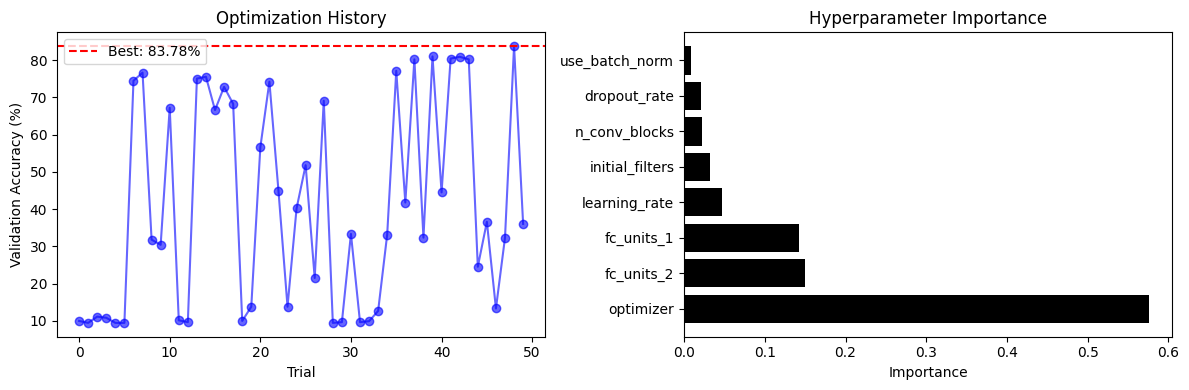

In [ ]:
# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Optimization history
axes[0].set_title('Optimization History')

# Trial values over time
trial_numbers = [t.number for t in study.trials if t.value is not None]
trial_values = [t.value for t in study.trials if t.value is not None]

axes[0].plot(trial_numbers, trial_values, 'ko-', alpha=0.6)
axes[0].axhline(
    y=study.best_value,
    color='r', linestyle='--', label=f'Best: {study.best_value:.2f}%'
)
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].legend()

# Hyperparameter importance (if enough trials completed)
axes[1].set_title('Hyperparameter Importance')
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if len(completed_trials) >= 5:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    axes[1].set_xlabel('Importance')
    axes[1].barh(params, values, color='black')

else:
    axes[1].text(
        0.5, 0.5,
        'Not enough completed trials\nfor importance analysis', 
        ha='center', va='center', transform=axes[1].transAxes
    )

plt.tight_layout()
plt.show()

## 4. Train final model with best hyperparameters

### 4.1. Create optimized model

In [15]:
# Extract best hyperparameters
best_params = study.best_trial.params

print('Best hyperparameters:')
for key, value in best_params.items():
    print(f'  {key}: {value}')

# Create model with best hyperparameters
best_model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    fc_units_1=best_params['fc_units_1'],
    fc_units_2=best_params['fc_units_2'],
    dropout_rate=best_params['dropout_rate'],
    use_batch_norm=best_params['use_batch_norm']
).to(device)

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

elif best_params['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(
        best_model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9)
    )

else:  # RMSprop
    best_optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

# Set cross-entropy loss
criterion = nn.CrossEntropyLoss()

Best hyperparameters:
  n_conv_blocks: 4
  initial_filters: 32
  fc_units_1: 512
  fc_units_2: 256
  dropout_rate: 0.36557880554886374
  use_batch_norm: True
  learning_rate: 0.00041902537769928077
  optimizer: Adam


### 4.2. Train optimized model

In [16]:
%%time

history = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=best_optimizer,
    epochs=n_epochs_final,
    print_every=10
)

Epoch 1/200 - loss: 2.1741 - accuracy: 17.58% - val_loss: 2.9218 - val_accuracy: 10.41%
Epoch 10/200 - loss: 1.0422 - accuracy: 63.21% - val_loss: 1.2001 - val_accuracy: 60.11%
Epoch 20/200 - loss: 0.7443 - accuracy: 74.42% - val_loss: 0.7901 - val_accuracy: 72.51%
Epoch 30/200 - loss: 0.6057 - accuracy: 78.90% - val_loss: 0.6848 - val_accuracy: 76.99%
Epoch 40/200 - loss: 0.5043 - accuracy: 82.60% - val_loss: 0.5938 - val_accuracy: 79.54%
Epoch 50/200 - loss: 0.4249 - accuracy: 85.14% - val_loss: 0.5665 - val_accuracy: 81.33%
Epoch 60/200 - loss: 0.3708 - accuracy: 86.89% - val_loss: 0.5764 - val_accuracy: 81.36%
Epoch 70/200 - loss: 0.3163 - accuracy: 89.02% - val_loss: 0.5650 - val_accuracy: 82.27%
Epoch 80/200 - loss: 0.2683 - accuracy: 90.53% - val_loss: 0.5836 - val_accuracy: 82.50%
Epoch 90/200 - loss: 0.2315 - accuracy: 91.76% - val_loss: 0.6302 - val_accuracy: 82.15%
Epoch 100/200 - loss: 0.2073 - accuracy: 92.62% - val_loss: 0.5873 - val_accuracy: 83.13%
Epoch 110/200 - loss:

### 4.3. Learning curves

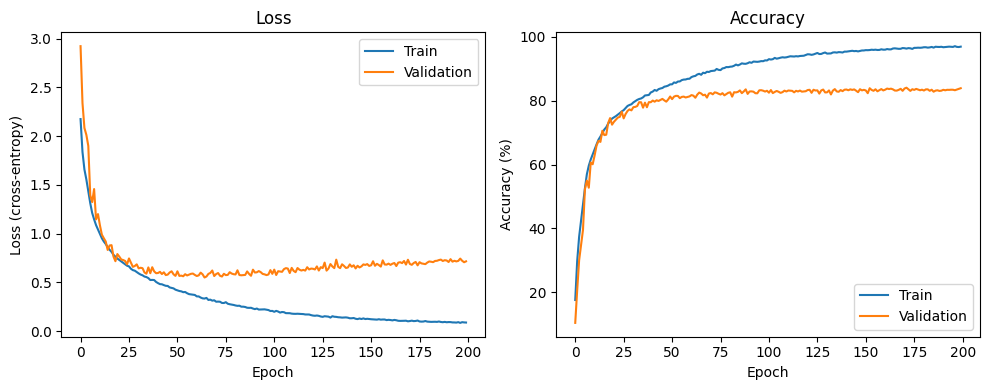

In [17]:
fig, axes = plot_learning_curves(history)
plt.show()

## 5. Evaluate optimized model on test set

### 5.1. Calculate test accuracy

In [18]:
test_accuracy, predictions, true_labels = evaluate_model(best_model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 84.03%


### 5.2. Per-class accuracy

In [19]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 86.90%
automobile  : 91.80%
bird        : 73.50%
cat         : 63.20%
deer        : 83.10%
dog         : 79.20%
frog        : 90.60%
horse       : 89.30%
ship        : 90.00%
truck       : 92.70%


### 5.3. Confusion matrix

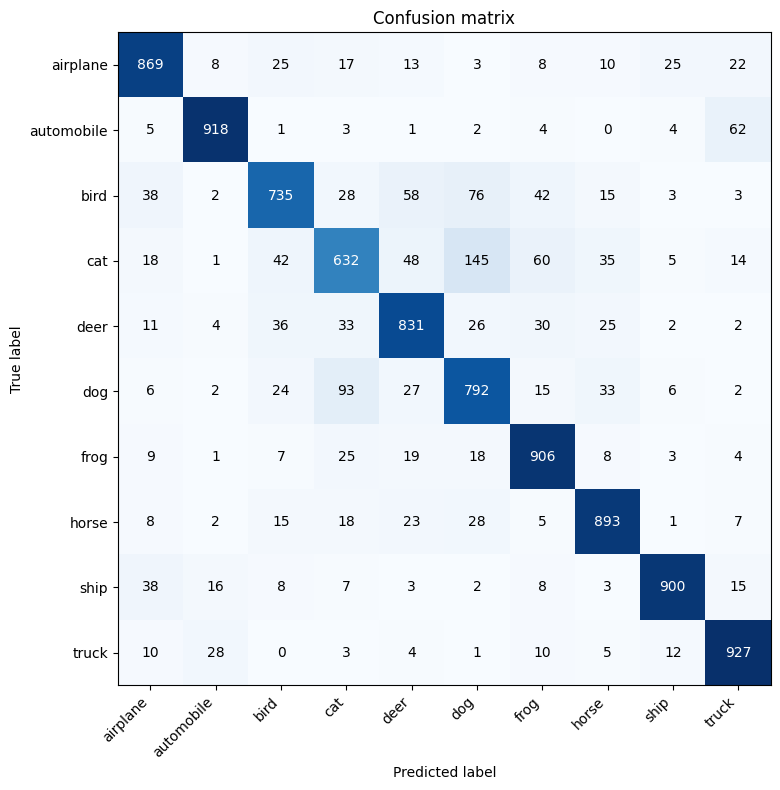

In [20]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 5.4. Predicted class probability distributions

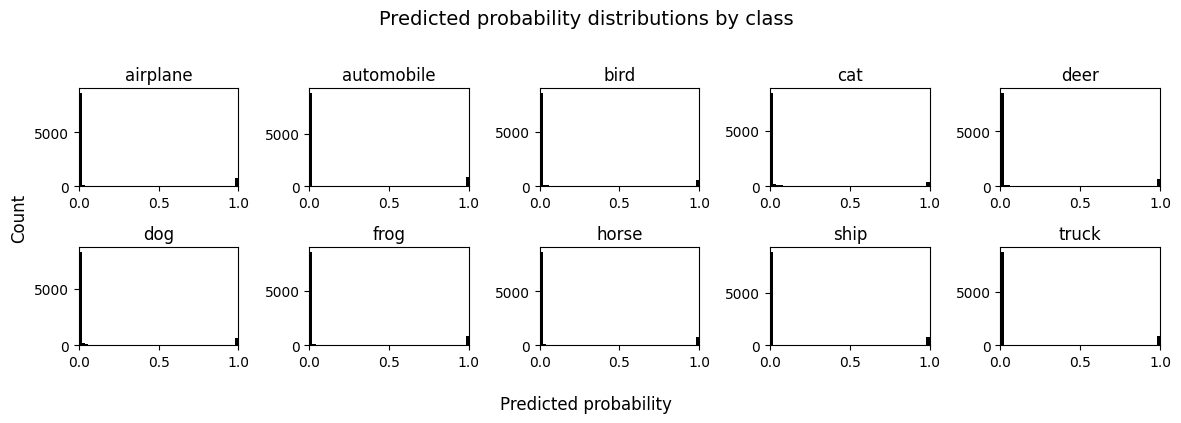

In [21]:
# Get predicted probabilities for all test samples
best_model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = best_model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 5.5. Evaluation curves

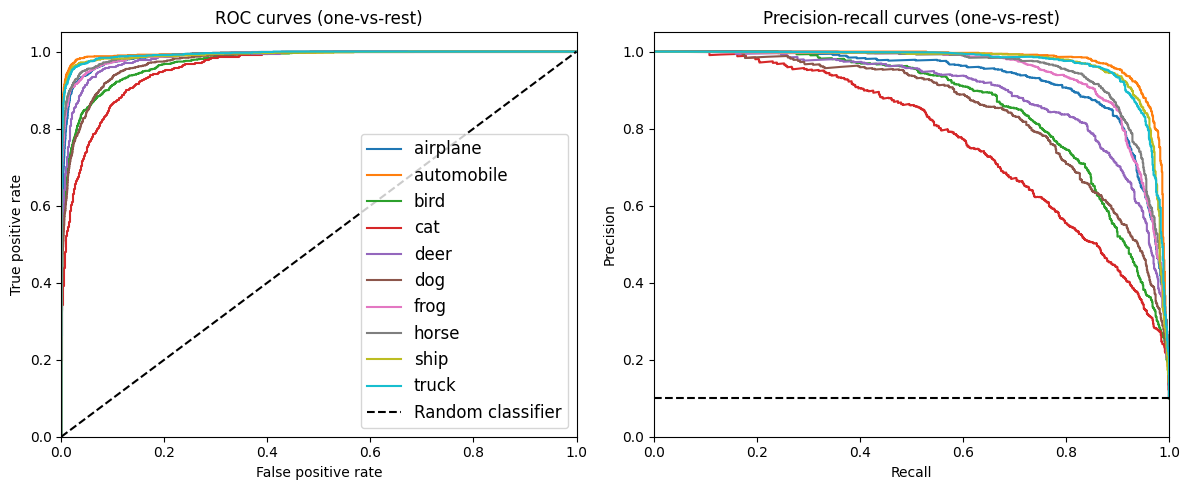

In [22]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 6. Save optimized model and hyperparameters

In [23]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'optimized_cnn.pth'

torch.save({
    'model_state_dict': best_model.state_dict(),
    'optimizer_state_dict': best_optimizer.state_dict(),
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/optimized_cnn.pth
Test accuracy: 84.03%
